In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import os
import glob

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10



from datetime import datetime, timedelta,date
from __future__ import division

import plotly.offline as pyoff
import plotly.graph_objs as go

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold, cross_val_score, train_test_split #split data in testing and training portion
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing #standardize data
from sklearn.linear_model import LinearRegression

import seaborn as sns



In [220]:
path = os.getcwd() #get current working directory
ls = []
i = 2015
while(i < 2017):
    csv_folders = glob.glob(os.path.join(path, "bikeshare_data/" + str(i))) #find all the folders that start with bikeshare_data/

    for f in csv_folders:
        ls.append(glob.glob(os.path.join(path, "bikeshare_data\\" + str(i) + "\\" + "*.xlsx"))[0]) #append found files
    
    i +=1

number_of_bikes = []

df_2015 = len(pd.read_excel(ls[0]))
df_2016 = len(pd.read_excel(ls[1]))

number_of_bikes.append(df_2015)
number_of_bikes.append(df_2016)

print(number_of_bikes)

[5584, 367962]


In [222]:
#same as above add all known csv files from 2017 to 2023 to ls array in order to have easier access to them
i = 2017
while(i < 2023):
    for f in csv_folders:
            csv_files = glob.glob(os.path.join(path, "bikeshare_data\\" + str(i) + "\\" + "*.csv"))
            ls.append(csv_files)                                                                       
    i += 1

#find how many rows are in each dataframe based off the yaer
num_rows_df_2017 = len(pd.concat(map(pd.read_csv,ls[2]))) #concat merges all the csv files in the subfolder in to 1
number_of_bikes.append(num_rows_df_2017) #append how many bikes were used during the year
num_rows_df_2018 = len(pd.concat(map(pd.read_csv,ls[3])))
number_of_bikes.append(num_rows_df_2018)
num_rows_df_2019 = len(pd.concat(map(pd.read_csv,ls[4])))
number_of_bikes.append(num_rows_df_2019)
num_rows_df_2020 = len(pd.concat(map(pd.read_csv,ls[5])))
number_of_bikes.append(num_rows_df_2020)

df_2021 = [] #for the year 2021 there was a utf-8 issue so it requires different processing
index = 0
num_rows = 0
for i in range(len(ls[6])): #for each file in the 2021 folder
    ls[6][i] = ls[6][i].replace("\\","/") #update the path
    temp_df = pd.read_csv(ls[6][i],encoding= 'unicode_escape') #create a temporary dataframe 
    num_rows += len(temp_df) #add the number of rows from reach dataframe to the overall count
    
num_rows_df_2021 = num_rows

number_of_bikes.append(num_rows_df_2021) #append the count to the overall list of each year

ls_copy = ls #just in case

In [179]:
df = pd.DataFrame() #create empty data frame
df["Number of Bikes"] = number_of_bikes
df['Year'] = pd.date_range(start='2015', periods=len(df), freq='Y').year

df

,Number of Bikes,Year
0,5584,2015
1,367962,2016
2,1492369,2017
3,1922955,2018
4,2439517,2019
5,2911308,2020
6,3575182,2021


Text(0, 0.5, 'Number of Bikes ( /1000)')

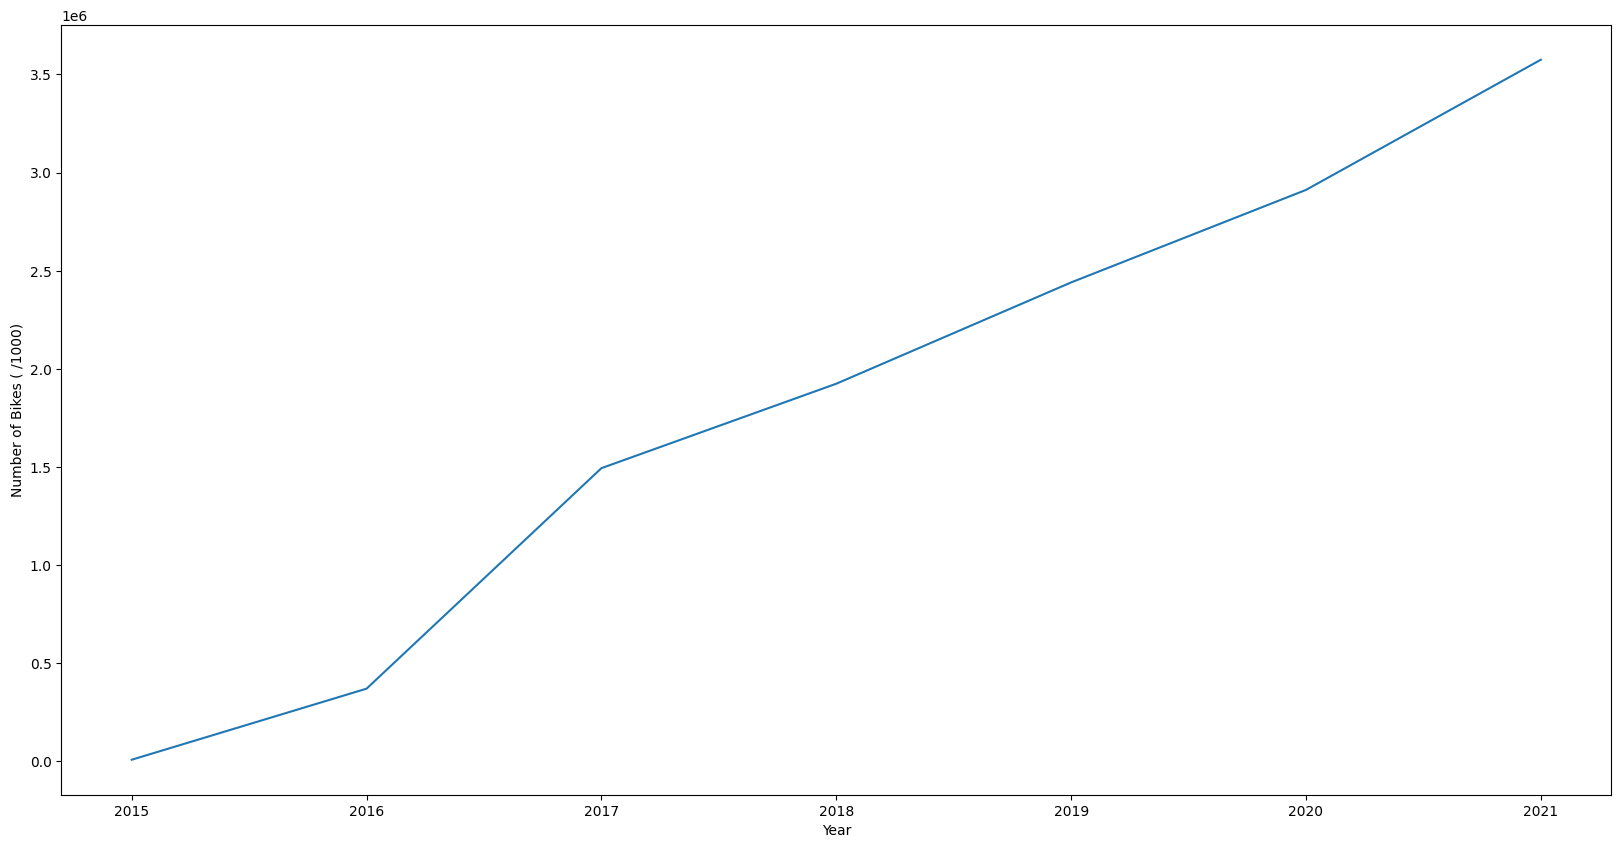

In [180]:
plt.plot(df['Year'].values.tolist(),df['Number of Bikes'].values.tolist())
plt.xlabel('Year')
plt.ylabel('Number of Bikes ( /1000)')

In [216]:
forecast = 3 #forecast variable represents how many years in the future I'm trying to predict
df['Prediction'] = df["Number of Bikes"].shift(-3) #Create a prediction row and keep 3 cells blank before inserting predicted values

#X datas4et feautures
#Y datatset is labels

X = np.array(df.drop(['Prediction'],1)) #drop prediction column in order to not corrupt preprocessing
X = preprocessing.scale(X) #standardize data setting the mean = 0 and std = 1

X_forecast = X[-forecast:] #preprocessing still accounts for last 3 years so we need to index the data to exclude the last 3 years
X = X[:-forecast] #all but the last 3 years

y = np.array(df['Prediction'])
y = y[:-forecast]


#ensured X and Y have same length

print("X_forecast :\n",X_forecast)
print("X :\n", X)
print("y:",y)


X_forecast :
 [[0.51685601 0.5       ]
 [0.90819877 1.        ]
 [1.45887115 1.5       ]]
X :
 [[-1.50205074 -1.5       ]
 [-1.20146424 -1.        ]
 [-0.26878742 -0.5       ]
 [ 0.08837647  0.        ]]
y: [1922955. 2439517. 2911308. 3575182.]


In [187]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4) # split train and test datasets using an 60/40 split
clf = LinearRegression() #initialize linear regression model and classifier
clf.fit(X_train,y_train) #initialize model with training data

confidence = clf.score(X_test,y_test) #score our data on test datasets to ensure we have an accurate model
confidence #the closer to 1 the confidence level is the more accurate the model

0.8173128223465972

In [188]:
forecast_predicted = clf.predict(X_forecast) #predict what is our model going to predict on the 3 years were looking for
forecast_predicted #predicted values for the next 3 years

array([3683232.21358751, 4068479.2238883 , 4530763.74381218])

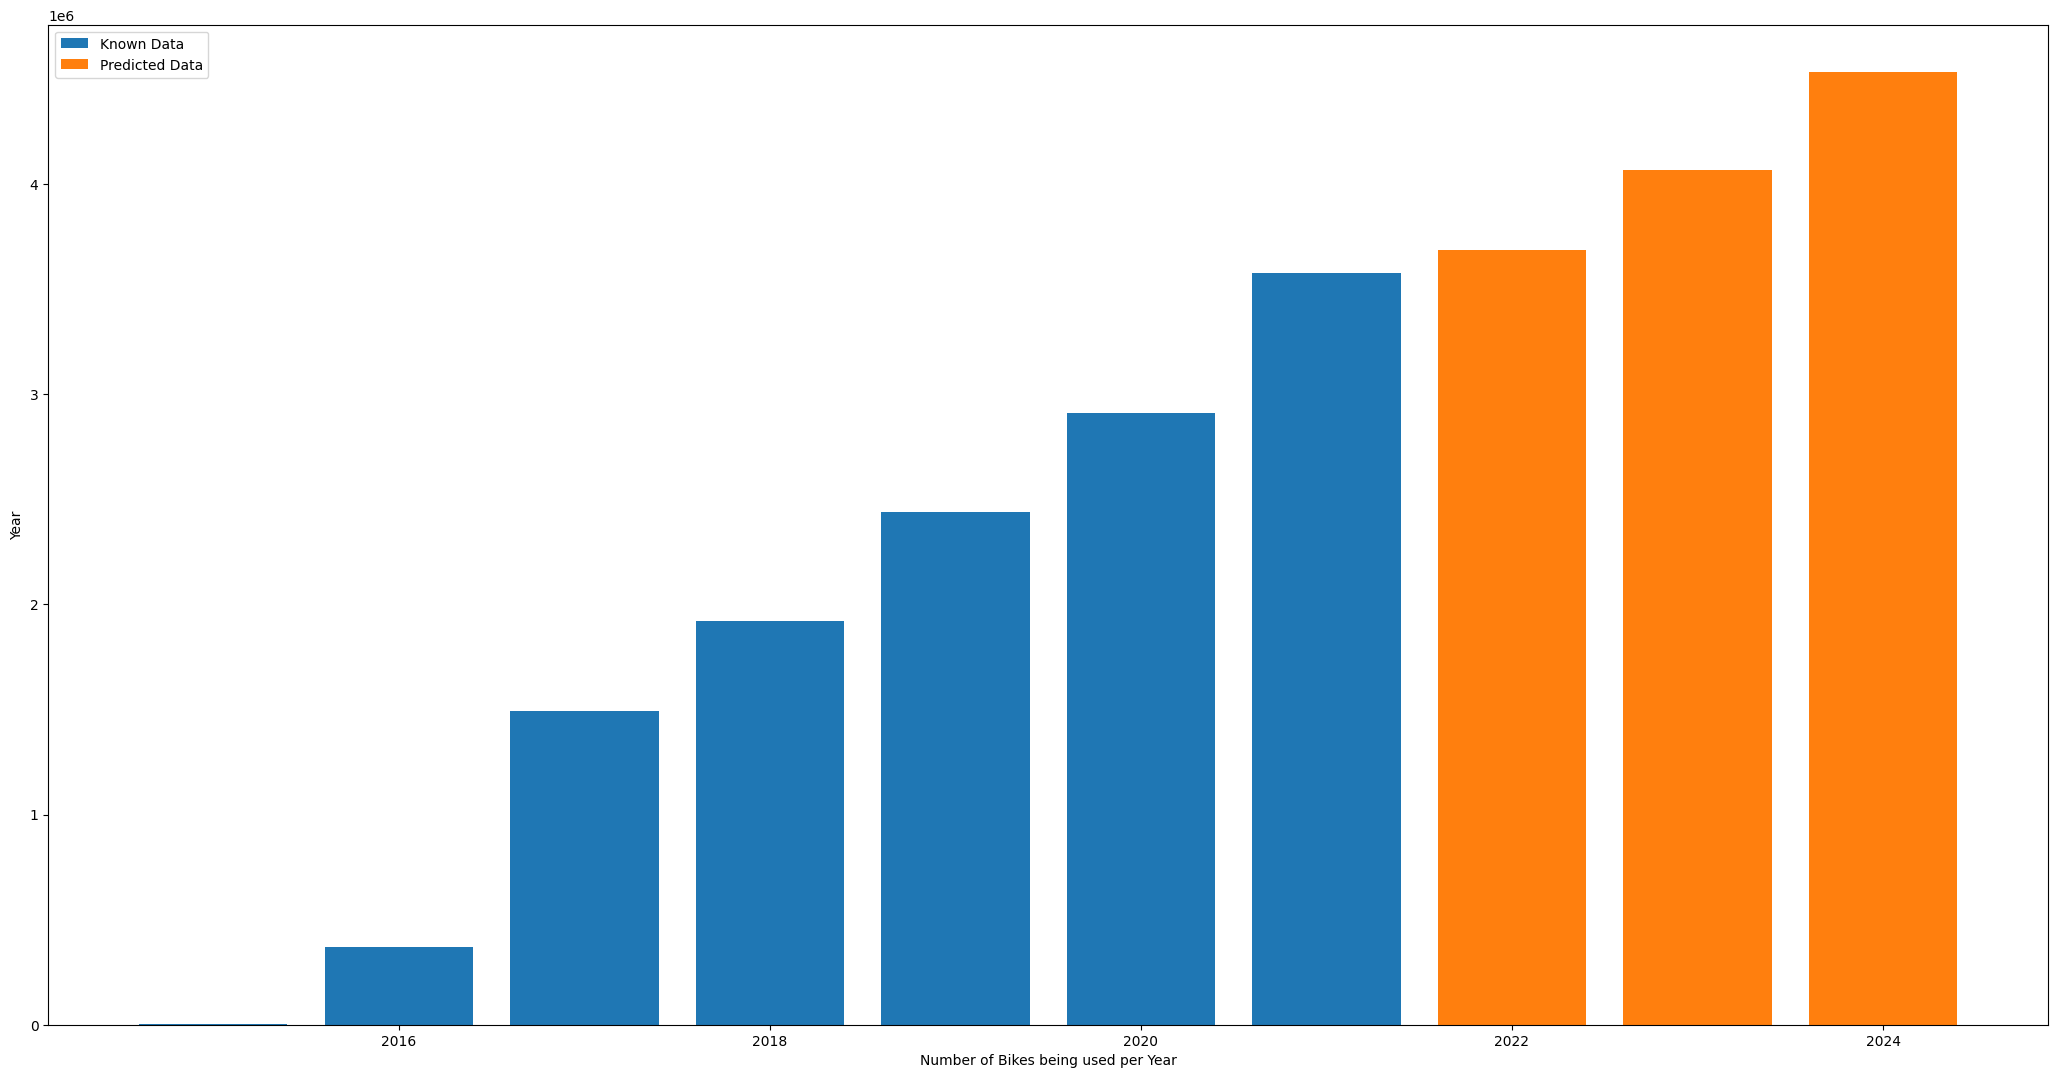

In [244]:
#Plot the data that we have (blue) from 2015 -> 2021 and the predicted data (orange) from 2022 -> 2024

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = df['Year']
number_of_ppl = df["Number of Bikes"]
ax.bar(langs,number_of_ppl, label="Known Data")

pred_year = [2022,2023,2024]
pred_number_of_ppl = forecast_predicted
ax.bar(pred_year,pred_number_of_ppl, label= "Predicted Data")
plt.legend(loc="upper left")

plt.xlabel("Number of Bikes being used per Year", fontsize=20)
plt.ylabel("Year")

plt.show()

#I chose a bar graph to emphasize the predicted growth of the number of bikes being used

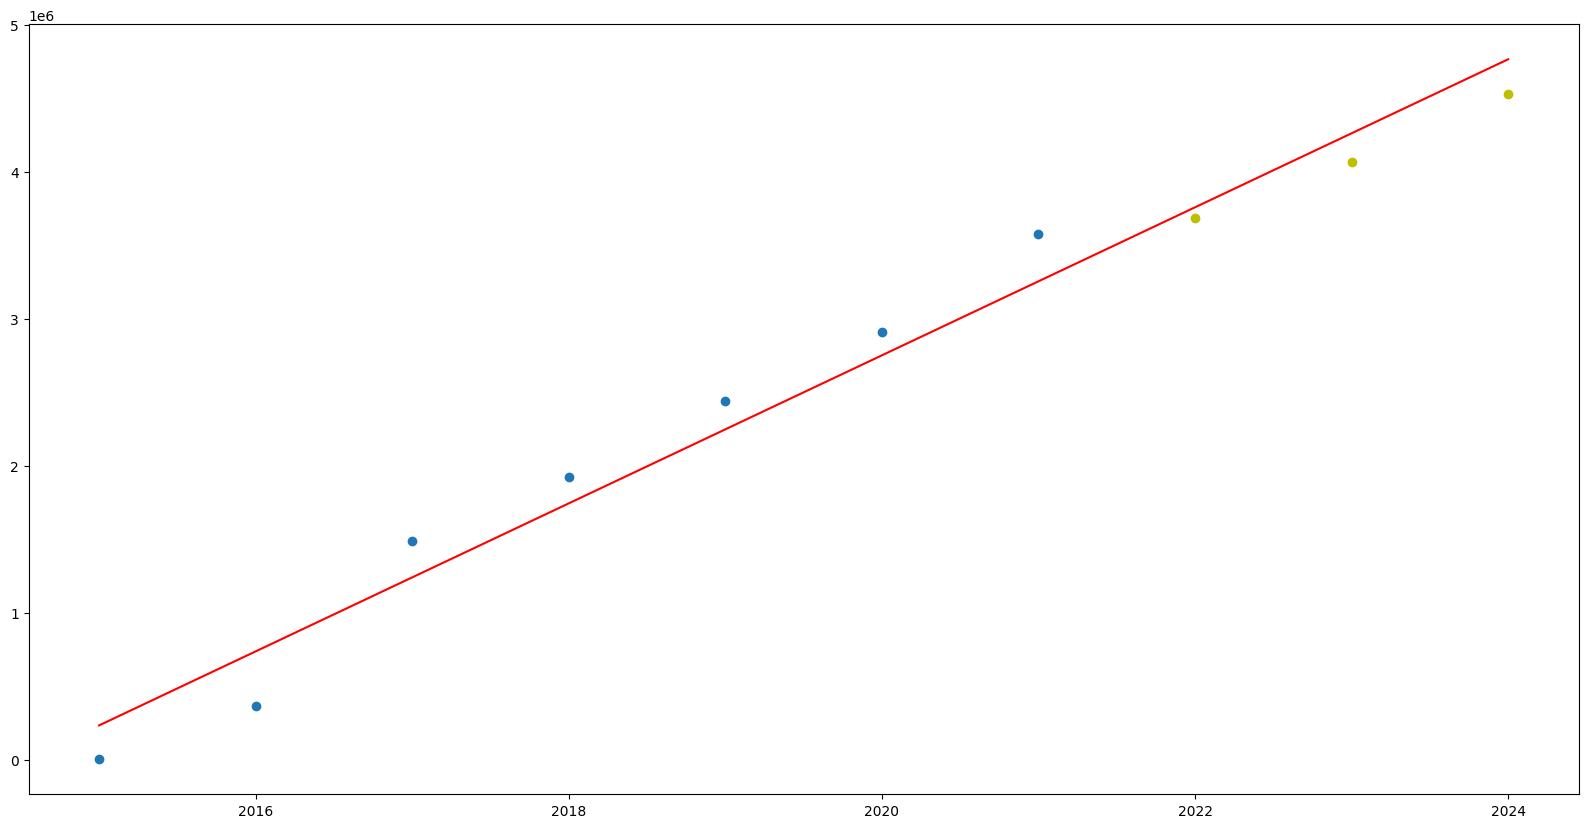

In [190]:
dates = pd.date_range(start='2022', periods=3, freq='Y').year
plt.scatter(dates, forecast_predicted, color="y")
# df["Number of Bikes"].plot(color="g")
plt.scatter(df["Year"],df["Number of Bikes"])

ls = list(df["Number of Bikes"])
ls += list(forecast_predicted)

y = np.array(ls)
x = np.array([2015,2016,2017,2018,2019,2020,2021,2022,2023,2024])
m, b = np.polyfit(x, y, 1) #find the slope and y_0 of the linear regression line
plt.plot(x, m*x+b,color = "red") #plot linear regression line

#ADD LEGENDS

In [241]:
# I excluded the year 2022 from the original dataset to test the accuracy of them model

num_rows_df_2022 = len(pd.concat(map(pd.read_csv,ls_copy[-1]))) #calculate how many times bikes have been used so far in 2022

print("How many bikes have been used so far in 2022:", num_rows_df_2022)
print("How many bikes are predicted to be used:", int(forecast_predicted[0]))

print("\nWhich means that", int(forecast_predicted[0] - num_rows_df_2022), "or more have be used in the next 4 months" )
num_of_bikes_before_2022_end = forecast_predicted[0] - num_rows_df_2022 

#check first 4 months of august
first_4 = ls_copy[-1][0:4]
num_first_4 = len(pd.concat(map(pd.read_csv,first_4)))

#check months 5-8 of august
middle_4 = ls_copy[-1][4:]
num_middle_4 = len(pd.concat(map(pd.read_csv,middle_4)))

print("\nNumber of bikes used between Janauary and April:", num_first_4)
print("Number of bikes used between May and August:", num_middle_4)

average = (num_first_4 + num_middle_4) // 2

print("Average number of uses during the two first thirds of the yaer:",average)

print("\nTherefore the model is underestimating how many people would use bikes, \nhowever the number of uses may drop when the winter months start!")


How many bikes have been used so far in 2022: 3017662
How many bikes are predicted to be used: 3683232

Which means that 665570 or more have be used in the next 4 months

Number of bikes used between Janauary and April: 521633
Number of bikes used between May and August: 2496029
Average number of uses during the two first thirds of the yaer: 1508831

Therefore the model is underestimating how many people would use bikes, 
however the number of uses may drop when the winter months start!
